## Correlations between TMT-B test scores and exposure/mediator variables 

This code extracts TMT-B scores from ARIC and FHS datasets, calculates Spearman's correlation values between exposure/mediator variables and TMT-B scores (unadjusted and adjusted for age/sex/BMI), and plots a heatmap of correlation values. TMT-B scores show time to complete the test (min). 

In [1]:
# Load all necessary packages 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pingouin as pg

### First step: extract Trail Making Test B (TMT-B) scores from data

In [2]:
# Loading in data for Framingham Heart Study (FHS) first 
fhs_df = pd.read_excel("mastersheet.xlsx", sheet_name="DementiaFHS") 
np_dates_df = pd.read_csv("datasets_FHS_ARIC_CHS_SHHS\\dataset_Framingham_Offspring_2023b\\Datasets\\CSV\\vr_npdates_2019_a_1249d.csv")
np_df = pd.read_csv("datasets_FHS_ARIC_CHS_SHHS\\dataset_Framingham_Offspring_2023b\\Datasets\\CSV\\vr_np_2018_a_1185d.csv")
mediation_df = pd.read_csv("mediation_model_dataset.csv")

In [3]:
# Ensure PID fields are all strings and are uniform 
for df in [fhs_df, np_dates_df, np_df, mediation_df]:
    df["PID"] = df["PID"].astype(str).str.strip()

# Extracting list of final PIDs from mediation model 
pid_list = set(mediation_df["PID"])

# Creating a subset of FHS PIDs only 
fhs_df = fhs_df[fhs_df["PID"].isin(pid_list)].copy() 
print(len(fhs_df))

486


In [4]:
# Merge neuropsych testing dates and filter where NP_DATE > days_studyv1 (psg date) 
merged = fhs_df.merge(np_dates_df, on="PID", how="inner")
filtered_pids = merged[merged["NP_DATE"] > merged["days_studyv1"]].copy()
print(f"Filtered PIDs with NP_DATE > days_studyv1: {len(filtered_pids)}")

# Check duplicate test counts (np testing done several times after PSG date) 
dup_counts = filtered_pids["PID"].value_counts()
print(f"Total with duplicates: {(dup_counts > 1).sum()}")
print(f"No dupes: {(dup_counts == 1).sum()}")

# Have NP testing from 463 total participants, 58 with only one test, and 405 with multiple 

Filtered PIDs with NP_DATE > days_studyv1: 1589
Total with duplicates: 405
No dupes: 58


In [5]:
# Will use the first instance of neuropsych testing
filtered_np_dates = filtered_pids.sort_values("NP_DATE").drop_duplicates(subset="PID", keep="first")
print(len(filtered_np_dates))

# filtered_np_dates is now the final df with the earliest test date for all 463 participants 

463


In [6]:
# Making PID column uniform 
np_df["PID"] = np_df["PID"].astype(str).str.strip()
filtered_np_dates["PID"] = filtered_np_dates["PID"].astype(str).str.strip()

# Merge dates with np_df to extract scores, keep only the relevant columns 
first_tmtb = filtered_np_dates.merge(
    np_df[["PID", "NP_DATE", "TRAILSB"]],
    on=["PID", "NP_DATE"],
    how="left"
)

# Drop rows where TRAILSB test is missing. A remaining 447 people have data. 
final_tmtb_fhs = first_tmtb[first_tmtb["TRAILSB"].notna()].copy()

# Calculate date of test from PSG date 
final_tmtb_fhs["npdate_from_psg"] = final_tmtb_fhs["NP_DATE"]-final_tmtb_fhs["days_studyv1"]

# Note: TRAILSB is stored as time to complete in minutes 

In [7]:
# Repeat process for ARIC dataset
# ARIC stores data separately for each neuropsych test. V5 is the first instance 
aric_v5 = pd.read_csv('C:\\Users\\vkatraga\\Documents\\VK SHHS Project\\datasets_FHS_ARIC_CHS_SHHS\\dataset_ARIC_2024b\\Main_Study\\v5\\CSV\\ncs.csv')
aric_np_dates = pd.read_csv('C:\\Users\\vkatraga\\Documents\\VK SHHS Project\\datasets_FHS_ARIC_CHS_SHHS\\dataset_ARIC_2024b\\Main_Study\\v5\\CSV\\derive51.csv')
aric_df = pd.read_excel("mastersheet.xlsx", sheet_name="DementiaARIC")

# Standardize PID columns 
aric_v5.rename(columns={"ID_C": "PID"}, inplace=True)
aric_np_dates.rename(columns={"ID_C": "PID"}, inplace=True)

aric_v5["PID"] = aric_v5["PID"].astype(str).str.strip()
aric_df["PID"] = aric_df["PID"].astype(str).str.strip()
aric_np_dates["PID"] = aric_v5["PID"].astype(str).str.strip()

In [8]:
# Filter out ARIC PIDs from mediation dataset 
pid_list = set(mediation_df["PID"])
aric_pid_filtered = aric_df[aric_df["PID"].isin(pid_list)].copy() 
print(len(aric_pid_filtered))

#aric_pid_filter has the pids that are in med list 

1537


In [9]:
# Ensuring no duplicates by date 
dups = aric_np_dates.duplicated(subset=["PID", "V5DATE51_DAYS"], keep=False)
print(f"Number of PID + date duplicates: {dups.sum()}")

# Ensure no duplicates by PID 
dup_counts = aric_np_dates["PID"].value_counts()
print(f"Number of PIDs with duplicates: {(dup_counts > 1).sum()}")

Number of PID + date duplicates: 0
Number of PIDs with duplicates: 0


In [10]:
# Merge dates and filter where NP_DATE > days_studyv1

aric_df_date = aric_pid_filtered.merge(aric_np_dates[["PID", "V5DATE51_DAYS"]], on="PID", how="inner")
aric_v5_pids = aric_df_date[aric_df_date["V5DATE51_DAYS"] > aric_df_date["days_studyv1"]].copy()

# 1021 participants have tests from V5, stored in <aric_v5_pids>

In [11]:
# Now checking if other participants had their earliest NP test during Visit 6 

missing_pids = set(aric_pid_filtered["PID"]) - set(aric_v5_pids["PID"])
aric_v6 = pd.read_csv('datasets_FHS_ARIC_CHS_SHHS\\dataset_ARIC_2024b\\Main_Study\\v6\\CSV\\ncs.csv')

aric_v6.rename(columns={"ID_C": "PID"}, inplace=True)
aric_v6["PID"] = aric_v6["PID"].astype(str).str.strip()

in_v6 = aric_v6[aric_v6["PID"].isin(missing_pids)]

# Extract only the columns relevant to TMT-B 
v6_pids_df = in_v6[["PID", "NCS10B", "NCS10C"]].copy()

# Now merge NP test dates 
v6_dates = pd.read_csv('datasets_FHS_ARIC_CHS_SHHS\\dataset_ARIC_2024b\\Main_Study\\v6\\CSV\\derive61.csv')
v6_dates.rename(columns={"ID_C": "PID"}, inplace=True)
v6_dates["PID"] = v6_dates["PID"].astype(str).str.strip()

v6_final = v6_pids_df.merge(v6_dates[["PID", "V6DATE61_DAYS"]], on="PID", how="inner")


# Min and seconds for time to complete test stored separately--combine into one 
v6_final["TMTB_time_min"] = v6_final["NCS10B"] + v6_final["NCS10C"]/60

# Drop missing values 
v6_final = v6_final[v6_final["TMTB_time_min"].notna()].copy()

# 12 new PIDs with data  
print("final num new participants:", len(v6_final))

final num new participants: 12


In [12]:
# Repeating process for Visit 7 
aric_v7 = pd.read_csv('datasets_FHS_ARIC_CHS_SHHS\\dataset_ARIC_2024b\\Main_Study\\v7\\CSV\\ncs.csv')
aric_v7.rename(columns={"ID_C": "PID"}, inplace=True)
aric_v7["PID"] = aric_v7["PID"].astype(str).str.strip()


missing_pids_afterv6 = missing_pids - set(in_v6["PID"])
in_v7 = aric_v7[aric_v7["PID"].isin(missing_pids_afterv6)]

# Copy only the relevant columns 
v7_pids_df = in_v7[["PID", "NCS10B", "NCS10C"]].copy()


# Merge in dates 
v7_dates = pd.read_csv('datasets_FHS_ARIC_CHS_SHHS\\dataset_ARIC_2024b\\Main_Study\\v7\\CSV\\derive71.csv')
v7_dates.rename(columns={"ID_C": "PID"}, inplace=True)
v7_dates["PID"] = v7_dates["PID"].astype(str).str.strip()
v7_final = v7_pids_df.merge(v7_dates[["PID", "V7DATE71_FOLLOWUPDAYS"]], on="PID", how="inner")

# Convert to minutes and drop missing values 
v7_final = v7_final[v7_final["NCS10B"].notna()].copy()
v7_final["TMTB_time_min"] = v7_final["NCS10B"] + v7_final["NCS10C"]/60

# 1 new PID with data 
print(len(v7_final))

1


In [13]:
# Append V6 and V7 dfs into one df 

v6_final.rename(columns={"V6DATE61_DAYS":"visit_date"}, inplace=True)
v7_final.rename(columns={"V7DATE71_FOLLOWUPDAYS":"visit_date"}, inplace=True)
v6_and_v7 = pd.concat([v6_final, v7_final], ignore_index=True)

print("number of new participants", len(v6_and_v7))

number of new participants 13


In [14]:
# Merge in <days_studyv1> to calculate NP date from PSG date 
v6_and_v7_final = v6_and_v7.merge(aric_df[["PID", "days_studyv1", "aric_dementia_from_psg", "aric_dod_from_psg"]], on="PID", how="inner")

In [15]:
# Select relevant columns from V5 

final_v5 = aric_v5_pids.drop(columns={"DEMDXL3_81", "COXDATE_DEMDXL3_81_FOLLOWUPDAYS", "DATEOFDEATH_FOLLOWUPDAYS"})
final_v5 = final_v5.merge(aric_v5[["PID", "NCS10B", "NCS10C"]], on="PID", how="inner")
final_v5["TMTB_time_min"] = final_v5["NCS10B"] + final_v5["NCS10C"]/60

final_v5 = final_v5[final_v5["TMTB_time_min"].notna()].copy()
final_v5.rename(columns={"V5DATE51_DAYS":"visit_date"}, inplace=True)
print(final_v5.columns)

Index(['PID', 'days_studyv1', 'aric_dementia_from_psg', 'aric_dod_from_psg',
       'visit_date', 'NCS10B', 'NCS10C', 'TMTB_time_min'],
      dtype='object')


In [16]:
# Merge all dfs together
final_aric_dataset = pd.concat([final_v5, v6_and_v7_final],ignore_index=True)

# Calculate NP date from PSG in case it's needed 
final_aric_dataset["npdate_from_psg"] = final_aric_dataset["visit_date"] - final_aric_dataset["days_studyv1"]

print(len(final_aric_dataset))

927


### Calculate correlation values from both FHS and ARIC 

In [17]:
# Creating final TMT-B df 
print(final_tmtb_fhs.columns)
fhs_tmtb = final_tmtb_fhs[["PID", "TRAILSB", "npdate_from_psg"]].copy()
print(fhs_tmtb.columns)

Index(['PID', 'DEM_STATUS', 'DEM_SURVDATE', 'DATEDTH', 'days_studyv1',
       'fhs_dementia_from_psg', 'fhs_dod_from_psg', 'idtype', 'NP_DATE',
       'TRAILSB', 'npdate_from_psg'],
      dtype='object')
Index(['PID', 'TRAILSB', 'npdate_from_psg'], dtype='object')


In [18]:
# Final ARIC df 
print(final_aric_dataset.columns)
aric_tmtb = final_aric_dataset[["PID", "TMTB_time_min", "npdate_from_psg"]].copy()
print(aric_tmtb.columns)

Index(['PID', 'days_studyv1', 'aric_dementia_from_psg', 'aric_dod_from_psg',
       'visit_date', 'NCS10B', 'NCS10C', 'TMTB_time_min', 'npdate_from_psg'],
      dtype='object')
Index(['PID', 'TMTB_time_min', 'npdate_from_psg'], dtype='object')


In [19]:
# Rename column to concatenate 
fhs_tmtb.rename(columns={"TRAILSB":"TMTB_time_min"}, inplace=True)

In [20]:
# Concatenate dfs
cognitive_df = pd.concat([aric_tmtb, fhs_tmtb], ignore_index=True)
print(len(cognitive_df))

1374


In [21]:
# Pull in the exposure/mediator values for correlation 
# Standardize the PID column first 
mediation_df["PID"] = mediation_df["PID"].astype(str).str.strip()

# Extract only PIDs we have cognitive data for 
final_pids = set(cognitive_df["PID"])
mediation_df_filtered = mediation_df[mediation_df["PID"].isin(final_pids)].copy()

# Extract exposure/mediator columns and relevant covariates
mediation_df_subset = mediation_df_filtered[["PID", "hb_desat", "avg_spo2_no_desat_NREM", "SP_DENS_all_C", "SP_CHIRP_all_C", "SP_R_PHASE_IF_all_C", 
                                 "age", "sex","bmi"]].copy()
print(mediation_df_subset.columns)
print(len(mediation_df_subset))

Index(['PID', 'hb_desat', 'avg_spo2_no_desat_NREM', 'SP_DENS_all_C',
       'SP_CHIRP_all_C', 'SP_R_PHASE_IF_all_C', 'age', 'sex', 'bmi'],
      dtype='object')
1374


In [22]:
# Merge exposure/mediators with cognitive df 
final_df = mediation_df_subset.merge(cognitive_df, on="PID", how="inner")
print(final_df.columns)

Index(['PID', 'hb_desat', 'avg_spo2_no_desat_NREM', 'SP_DENS_all_C',
       'SP_CHIRP_all_C', 'SP_R_PHASE_IF_all_C', 'age', 'sex', 'bmi',
       'TMTB_time_min', 'npdate_from_psg'],
      dtype='object')


In [23]:
# Define exposure/mediator variables, and results column 
variables = ["avg_spo2_no_desat_NREM", "hb_desat", "SP_DENS_all_C", "SP_CHIRP_all_C", "SP_R_PHASE_IF_all_C"]
results = []

# Covariates to adjust for 
covariates = ["age", "sex", "bmi"]

# Loop through the exposure/mediator - cognitive outcome pairings 
for var in variables:
    # Drop NAN rows, in case present 
    subset = final_df[[var, "TMTB_time_min"] + covariates].dropna()
    
    # UNADJUSTED Spearman calculation first 
    unadj = pg.corr(x=subset[var], y=subset["TMTB_time_min"], method="spearman")

    rho_unadj = unadj["r"].values[0]
    pval_unadj = unadj["p-val"].values[0]

    # ADJUSTED Spearman
    adj = pg.partial_corr(data=subset, x=var, y="TMTB_time_min", covar=covariates, method="spearman")

    rho_adj = adj["r"].values[0]
    pval_adj = adj["p-val"].values[0]

    # Store results into df 
    results.append({
        "Variable": var,
        "Unadjusted_rho": round(rho_unadj, 3),
        "Unadjusted_p": round(pval_unadj, 3),
        "Adjusted_rho": round(rho_adj, 3),
        "Adjusted_p": round(pval_adj, 3)
    })

# Convert from dictionary to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

                 Variable  Unadjusted_rho  Unadjusted_p  Adjusted_rho  \
0  avg_spo2_no_desat_NREM          -0.136         0.000        -0.038   
1                hb_desat           0.076         0.005        -0.031   
2           SP_DENS_all_C          -0.150         0.000        -0.028   
3          SP_CHIRP_all_C           0.099         0.000         0.018   
4     SP_R_PHASE_IF_all_C          -0.094         0.000         0.031   

   Adjusted_p  
0       0.158  
1       0.250  
2       0.299  
3       0.515  
4       0.247  


### Generating Figure

In [24]:
# import relevant packages 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

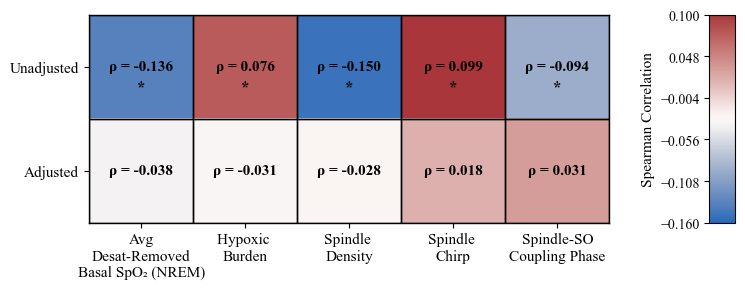

In [25]:
# Set font style 
plt.rcParams['font.family'] = 'Times New Roman'

# Pull in correlation results, transpose to make it 2 rows and 6 columns 
heatmap_matrix = results_df[["Unadjusted_rho", "Adjusted_rho"]].T.to_numpy()
pval_data = results_df[["Unadjusted_p", "Adjusted_p"]].T.to_numpy()

# Create figure plot 
fig, ax = plt.subplots(figsize=(10, 3)) 

# Set color scale and bar according to results 
vmin, vmax = -0.16, 0.1
norm = plt.Normalize(vmin, vmax)
cmap = sns.color_palette("vlag", as_cmap=True)

# Show heatmap
im = ax.imshow(heatmap_matrix, cmap=cmap, norm=norm)

# Axis labels
custom_x_labels = ['Avg\nDesat-Removed\nBasal SpO₂ (NREM)', 'Hypoxic \nBurden',
                   'Spindle \nDensity', 'Spindle \nChirp', 'Spindle-SO\nCoupling Phase']
custom_y_labels = ["Unadjusted", "Adjusted"]

ax.set_xticks(np.arange(len(custom_x_labels)))
ax.set_yticks([0, 1])
ax.set_xticklabels(custom_x_labels, fontsize=11, ha='center')
ax.set_yticklabels(custom_y_labels, fontsize=11)


# Annotate each cell with rho value 
for i in range(heatmap_matrix.shape[0]):
    for j in range(heatmap_matrix.shape[1]):
        rho = heatmap_matrix[i, j]
        ax.text(j, i, f'ρ = {rho:.3f}', ha='center', va='center', fontsize=11, color='black', fontweight='bold')

# Rectangle borders around cells 
for i in range(heatmap_matrix.shape[0]):
    for j in range(heatmap_matrix.shape[1]):
        rect = plt.Rectangle((j - 0.5, i - 0.5), 1, 1, fill=False, edgecolor='black', linewidth=1)
        ax.add_patch(rect)

# Add p-value asterisk notation 
for i in range(pval_data.shape[0]):
    for j in range(pval_data.shape[1]):
        pval = pval_data[i, j]
        if pval<0.05:
            ax.text(j, i + 0.2, f'*', ha='center', va='center', fontsize=12, color='black', fontweight='bold')
        elif pval<0.01:
            ax.text(j, i + 0.3, f'**', ha='center', va='center', fontsize=12, color='black', fontweight='bold')

# Thicken outer spines for clarity 
for spine in ax.spines.values():
    spine.set_linewidth(1)

# Set heatmap colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=1)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label("Spearman Correlation", fontsize=11)
cbar.set_ticks(np.linspace(-0.16, 0.1, 6))
cbar.ax.yaxis.set_ticks_position('left')   
cbar.ax.yaxis.set_label_position('left')   


# Save figure and show
plt.tight_layout()
#plt.savefig("FIGURE NAME.png", dpi=600, bbox_inches='tight')
plt.show()